In [20]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [21]:
_clear = ['bingroup']

def _clear_prop(trace, prop):
    if hasattr(trace, prop):
        trace.update({prop: None})
        
def _clear_props(traces):
    for trace in traces:
        for prop in _clear:
            _clear_prop(trace, prop)

def left_right(left, right, width=700, height=250, **kwargs):
    fig = make_subplots(cols=2, **kwargs)
    fig.update_layout(width=width, height=height)
    
    t1 = next(left.select_traces())
    t2 = next(right.select_traces())
    _clear_props([t1, t2])
    fig.add_trace(t1, row=1, col=1)
    fig.add_trace(t2, row=1, col=2)
    return fig

def margin(fig, **kwargs):
    return fig.update_layout(margin=kwargs)

In [22]:
csv_file = 'data/cleaned_purpleair_aqs/Full24hrdataset.csv'
usecols = ['Date', 'ID', 'region', 'PM25FM', 'PM25cf1', 'TempC', 'RH', 'Dewpoint']
full_df = (pd.read_csv(csv_file, usecols=usecols, parse_dates=['Date'])
        .dropna())
full_df.columns = ['date', 'id', 'region', 'pm25aqs', 'pm25pa', 'temp', 'rh', 'dew']

(ch:pa_eda)=
# Exploring PurpleAir and AQS Measurements 

Before we begin to model, let's explore the cleaned dataset of matched AQS and PurpleAir PM2.5 readings. 

In [23]:
full_df

,date,id,region,pm25aqs,pm25pa,temp,rh,dew
0,2019-05-17,AK1,Alaska,6.7,8.62,18.03,38.56,3.63
1,2019-05-18,AK1,Alaska,3.8,3.49,16.12,49.40,5.44
2,2019-05-21,AK1,Alaska,4.0,3.80,19.90,29.97,1.73
...,...,...,...,...,...,...,...,...
12427,2019-02-20,WI6,North,15.6,25.30,1.71,65.78,-4.08
12428,2019-03-04,WI6,North,14.0,8.21,-14.38,48.21,-23.02
12429,2019-03-22,WI6,North,5.8,9.44,5.08,52.20,-4.02


We've included an explanation for each of the columns below.

| Column  | Description                                                                                                                      |
|---------|----------------------------------------------------------------------------------------------------------------------------------|
| date    | Date of the observation                                                                                                          |
| id      | A unique label for a site, formatted as the US state abbreviation with a number. (We performed data cleaning for site ID `CA1`.) |
| region  | The name of the region, which corresponds to a group of sites. (The `CA1` site is located in the `West` region.)                 |
| pm25aqs | The PM2.5 measurement from the AQS sensor.                                                                                       |
| pm25pa  | The PM2.5 measurement from the PurpleAir sensor.                                                                                 |
| temp    | Temperature, in Celcius.                                                                                                         |
| rh      | Relative humidity, ranging from 0 to 100%.                                                                                       |
| dew     | The dew point of the air. (Higher dew point means more moisture in the air.)                                                     |

In [24]:
full_df['id'].value_counts()

IA3    830
NC4    699
CA2    659
      ... 
WI3     12
MT1      8
WI5      3
Name: id, Length: 49, dtype: int64

We start with some simple visualizations, like a line plot of the weekly average air quality measurements over time.

In [25]:
ts_aqs_nc4 = (full_df.loc[full_df['id']=='NC4'].set_index('date')
 .resample('W')
 ['pm25aqs']
 .mean()
 .reset_index()
)

ts_pa_nc4 = (full_df.loc[full_df['id'] =='NC4'].set_index('date')
 .resample('W')
 ['pm25pa']
 .mean()
 .reset_index()
)

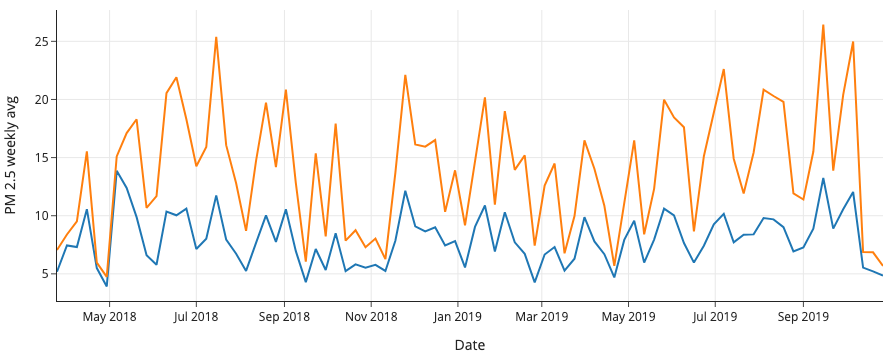

In [26]:
fig = px.line(ts_aqs_nc4, x='date', y='pm25aqs',
              title='',
              width=500, height=250)

fig.add_trace(go.Scatter(x=ts_pa_nc4['date'], y=ts_pa_nc4['pm25pa']))
fig.update_xaxes(title='Date')
fig.update_yaxes(title='PM 2.5 weekly avg')
fig.update_layout(showlegend=False)
fig.show()

We see that most PM2.5 values range between 5.0 and 15.0 µg m⁻³.

Next, we plot the distribution of both AQS and PurpleAir PM2.5 readings.

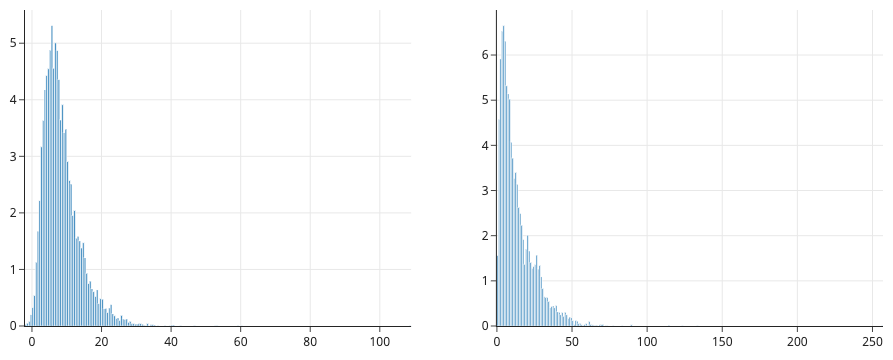

In [27]:
left = px.histogram(full_df, x='pm25aqs', histnorm='percent')
right = px.histogram(full_df, x='pm25pa', histnorm='percent')

fig = left_right(left, right, width=600, height=250)
fig.show()

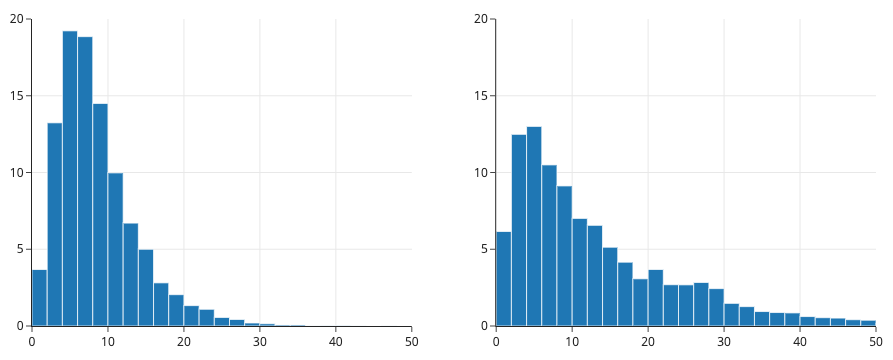

In [28]:
left = px.histogram(full_df, x='pm25aqs', histnorm='percent')
right = px.histogram(full_df, x='pm25pa', histnorm='percent')

fig = left_right(left, right, width=600, height=250)
fig.update_xaxes(range=[0,50])
fig.update_yaxes(range=[0,20])
fig.update_traces(xbins=dict(
        start=0.0, end=60.0, size=2
    ))
fig.show()

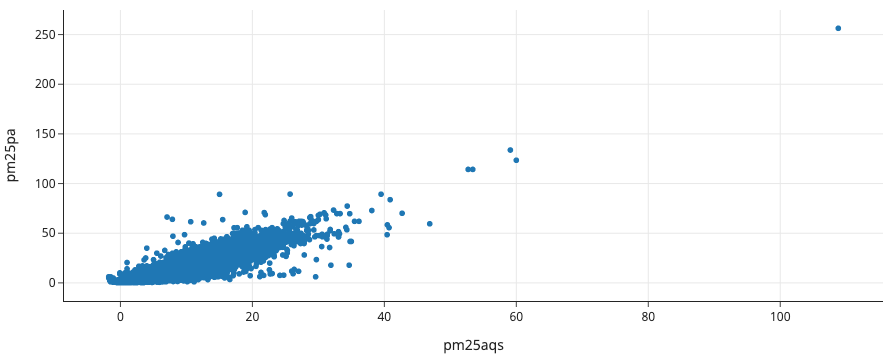

In [29]:
px.scatter(full_df, x='pm25aqs', y='pm25pa', width=350, height=350)

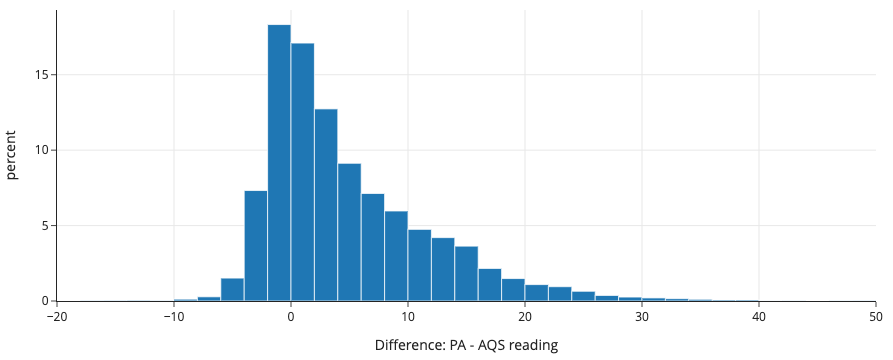

In [30]:
fig = px.histogram(full_df['pm25pa'] - full_df['pm25aqs'],
            histnorm='percent', width=400, height=250)

fig.update_xaxes(range=[-20,50], title="Difference: PA - AQS reading")
fig.update_traces(xbins=dict(
        start=-20.0, end=50.0, size=2
    ))
fig.update_layout(showlegend=False)
fig.show()

In [31]:
full_df = full_df.loc[(full_df['pm25aqs'] < 50)]

In [32]:
percs = np.arange(1, 100, 1)
aqs_qs = np.percentile(full_df['pm25aqs'], percs, interpolation='lower')
pa_qs = np.percentile(full_df['pm25pa'], percs, interpolation='lower')
perc_df = pd.DataFrame({'percentile': percs, 'aqs_qs':aqs_qs, 'pa_qs':pa_qs})

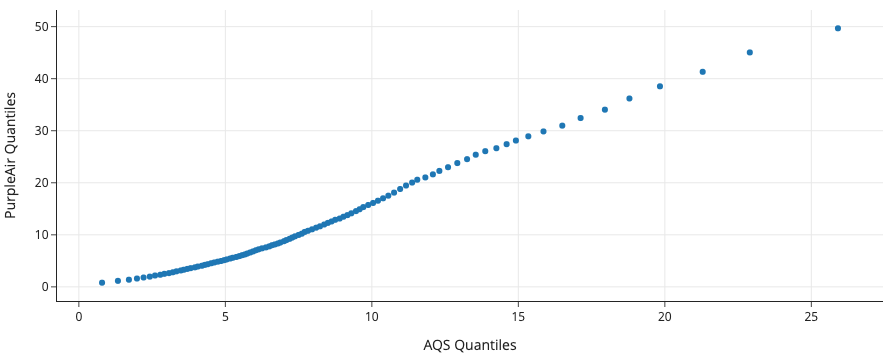

In [40]:
fig = px.scatter(perc_df, x='aqs_qs', y='pa_qs',
                 labels={'aqs_qs': 'AQS Quantiles',
                         'pa_qs': 'PurpleAir Quantiles'},
                 width=350, height=250)

fig.update_layout(showlegend=False)
fig

We see that the distributions of PM2.5 readings are skewed to the right. 

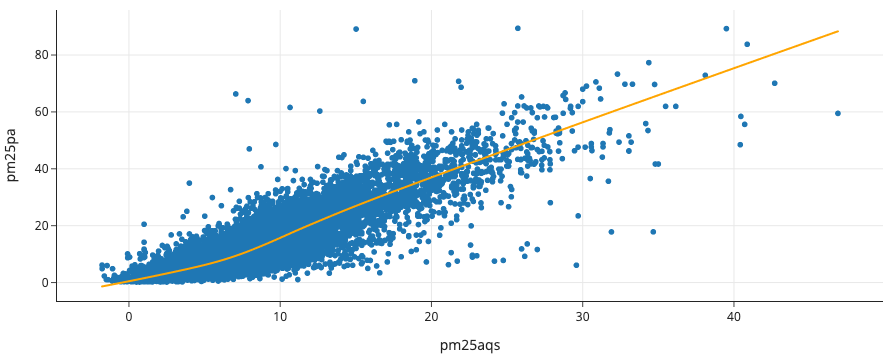

In [37]:
px.scatter(full_df, x='pm25aqs', y='pm25pa', 
           trendline='lowess', trendline_color_override="orange",
           width=350, height=350)

In [41]:
#full_df.corr(numeric_only=True)
np.corrcoef(full_df['pm25aqs'], full_df['pm25pa'])

array([[1.  , 0.88],
       [0.88, 1.  ]])

Lastly, we'll plot PurpleAir against AQS readings.

Before starting this analysis, we expected that PurpleAir measurements
would generally overestimate the PM2.5. 
And indeed, this is reflected in the scatter plot.